In [1]:
%run setup.py

# Read in MIST isochrones

In [2]:
class MIST_ISO: # from MIST website
    
    """
    
    Reads in MIST isochrone files.
    
    """
    
    def __init__(self, filename, verbose=True):
    
        """
        
        Args:
            filename: the name of .iso file.
        
        Usage:
            >> iso = read_mist_models.ISO('MIST_v1.0_feh_p0.00_afe_p0.0_vvcrit0.4.iso')
            >> age_ind = iso.age_index(8.0)
            >> logTeff = iso.isos[age_ind]['log_Teff']
            >> logL = iso.isos[age_ind]['log_L']
            >> plt.plot(logTeff, logL) #plot the HR diagram for logage = 8.0
            
        Attributes:
            version     Dictionary containing the MIST and MESA version numbers.
            abun        Dictionary containing Yinit, Zinit, [Fe/H], and [a/Fe] values.
            rot         Rotation in units of surface v/v_crit.
            ages        List of ages.
            num_ages    Number of isochrones.
            hdr_list    List of column headers.
            isos        Data.
            
        """
        
        self.filename = filename
        if verbose:
            print('Reading in: ' + self.filename)
            
        self.version, self.abun, self.rot, self.ages, self.num_ages, self.hdr_list, self.isos = self.read_iso_file()
        
    def read_iso_file(self):

        """
        Reads in the isochrone file.
        
        Args:
            filename: the name of .iso file.
        
        """
        
        #open file and read it in
        with open(self.filename) as f:
            content = [line.split() for line in f]
        version = {'MIST': content[0][-1], 'MESA': content[1][-1]}
        abun = {content[3][i]:float(content[4][i]) for i in range(1,5)}
        rot = float(content[4][-1])
        num_ages = int(content[6][-1])
        
        #read one block for each isochrone
        iso_set = []
        ages = []
        counter = 0
        data = content[8:]
        for i_age in range(num_ages):
            #grab info for each isochrone
            num_eeps = int(data[counter][-2])
            num_cols = int(data[counter][-1])
            hdr_list = data[counter+2][1:]
            formats = tuple([np.int32]+[np.float64 for i in range(num_cols-1)])
            iso = np.zeros((num_eeps),{'names':tuple(hdr_list),'formats':tuple(formats)})
            #read through EEPs for each isochrone
            for eep in range(num_eeps):
                iso_chunk = data[3+counter+eep]
                iso[eep]=tuple(iso_chunk)
            iso_set.append(iso)
            ages.append(iso[0][1])
            counter+= 3+num_eeps+2
        return version, abun, rot, ages, num_ages, hdr_list, iso_set  
        
    def age_index(self, age):
    
        """
        Returns the index for the user-specified age.
    
        Args:
            age: the age of the isochrone.
    
        """
    
        diff_arr = abs(np.array(self.ages) - age)
        age_index = np.where(diff_arr == min(diff_arr))[0][0]
    
        if ((age > max(self.ages)) | (age < min(self.ages))):
            print('The requested age is outside the range. Try between ' + str(min(self.ages)) + ' and ' + str(max(self.ages)))
        
        return age_index

In [4]:
fehs = np.arange(-2., 0.51, 0.25)

mistisos = [[], [], []]
for feh in fehs:
    filename = 'MIST_iso/MIST_iso_feh{:04.0f}.iso'.format(feh*100)
    f = MIST_ISO(work_dir+'modelling/'+filename,verbose=False)
    
    for i_iso, iso in enumerate(f.isos):
        d = pd.DataFrame(iso)
        d['Yinit']=f.abun['Yinit']
        d['Zinit']=f.abun['Zinit']
        d['[Fe/H]']=f.abun['[Fe/H]']
        mistisos[i_iso].append(d)

# Derive the theoretical [M/H]-mass edge

In [5]:
minis, masses, fehs = [[[], [], []] for i in range(3)]
for i_age in range(3):
    for i_iso, iso in enumerate(mistisos[i_age]):
        idx = (iso['phase']==3) & (iso['he_core_mass']>0)
        minis[i_age].append(iso.loc[idx,:].sort_values('initial_mass', ascending=True).iloc[0]['initial_mass'])
        masses[i_age].append(iso.loc[idx,:].sort_values('initial_mass', ascending=True).iloc[0]['star_mass'])
        fehs[i_age].append(iso.loc[idx,:].sort_values('initial_mass', ascending=True).iloc[0]['[Fe/H]'])
        
minis = [np.array(mini) for mini in minis]
masses = [np.array(mass) for mass in masses]
fehs = [np.array(feh) for feh in fehs]

import scipy
f_low_mini_limit = scipy.interpolate.interp1d(fehs[1], minis[1], kind='cubic', fill_value='extrapolate')
f_low_mass_limit = scipy.interpolate.interp1d(fehs[1], masses[1], kind='cubic', fill_value='extrapolate')

# Read in Galaxia sample

In [6]:
import ebf
galaxia=ebf.read(work_dir+"sample/kepler_galaxia_mrtd5.ebf")
Nstar = galaxia["alpha"].shape[0]
factor = int(Nstar/16000)
idx = np.arange(0,int(Nstar/factor))*factor
for key in galaxia.keys():
    galaxia[key] = galaxia[key][idx]
# print(synp.keys())
galaxia['nike'] = galaxia['numax']**0.75/galaxia['dnu']

# Plot Extended Figure 1 - Galaxia sample

In [13]:
def distance_to_zaheb_edge(xdata, ydata, xedge, yedge, 
                    distance="vertical", return_idx=False):
    if not (distance in ["vertical", "horizontal"]):
        raise ValueError("distance should be in ['vertical', 'horizontal']")

    if distance=="vertical": #y
        dist = np.zeros(xdata.shape[0])

        # first, condiser bottom part (low-mass)
        idx_data = (ydata <= yedge[np.argmin(xedge)])
        idx_edge = (yedge <= yedge[np.argmin(xedge)]) 
        Xa = np.array([xdata[idx_data]]).T
        Xb = np.array([xedge[idx_edge]]).T
        Y = scipy.spatial.distance.cdist(Xa, Xb)
        argdist = np.argmin(Y, axis=1)
        dist[idx_data] = (yedge[idx_edge][argdist] - ydata[idx_data])

        # next, consider the upper half part 
        idx_data = ~idx_data
        idx_edge = ~idx_edge
        Xa = np.array([xdata[idx_data]]).T
        Xb = np.array([xedge[idx_edge]]).T
        Y = scipy.spatial.distance.cdist(Xa, Xb)
        argdist = np.argmin(Y, axis=1)
        dist[idx_data] = (ydata[idx_data] - yedge[idx_edge][argdist])
            
    if distance=="horizontal": #x
        dist = np.zeros(xdata.shape[0])

        Xa = np.array([ydata]).T
        Xb = np.array([yedge]).T
        Y = scipy.spatial.distance.cdist(Xa, Xb)
        argdist = np.argmin(Y, axis=1)
        dist = (xedge[argdist] - xdata)

    if not return_idx:
        return dist
    else:
        return dist, ridx

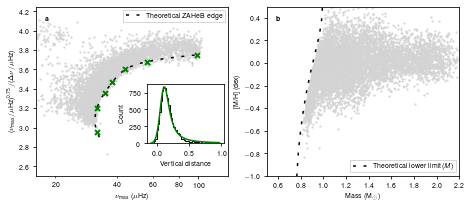

In [12]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset
from matplotlib.ticker import ScalarFormatter

# Plotting stuff
gridspec_kw = {'left':0.09, 'right':0.92, 'top':0.98, 'bottom':0.15, 'wspace':0.2, 'hspace':0.20}
fig, axes = plt.subplots(figsize=nature_size('double', ratio=0.4), nrows=1, ncols=2, squeeze=False, gridspec_kw=gridspec_kw)
# fig, axes = plt.subplots(figsize=[15,6], nrows=1, ncols=2, squeeze=False, gridspec_kw=gridspec_kw)
axes = axes.reshape(-1)

idx = galaxia['evstate'] == 2
# idx = galaxia['phase'] >2.999

# # 1 - metallicity vs. mass diagram
axes[1].scatter(galaxia['mact'][idx], galaxia['feh'][idx], c='lightgray', marker='.', s=5, rasterized=True)
axes[1].set_xlim(0.5, 2.2)
axes[1].set_ylim(-1., 0.5)
axes[1].set_xlabel('Mass (M$_\\odot$)')
axes[1].set_ylabel('[M/H] (dex)')


# 13.8Gyr limit
ym = np.arange(-1.5, 0.5, 0.01)
xm = f_low_mass_limit(ym)
axes[1].plot(xm, ym, linestyle=(0,(2,5)), color='k', label='Theoretical lower limit ($M$)')


idx = galaxia['evstate'] == 2
axes[0].scatter(galaxia['numax'][idx], galaxia['nike'][idx], c='lightgray', marker='.', s=5, rasterized=True)
axes[0].set_xlim(16,140)
axes[0].set_xscale('log',subs=[0,2,4,6,8,])
axes[0].set_ylim(2.5, 4.25)
axes[0].set_xlabel('$\\nu_{\\rm max}$ ($\\mu$Hz)')
axes[0].set_ylabel('$(\\nu_{\\rm max}/\\mu$Hz$)^{0.75}/(\\Delta\\nu/\\mu$Hz$)$ ')
axes[0].get_xaxis().set_major_formatter(ScalarFormatter())
axes[0].get_xaxis().set_minor_formatter(ScalarFormatter())

points=[(32., 2.95), (31.9, 3.2), (34.8, 3.36), (38, 3.47), (44, 3.6), (56, 3.68), (98, 3.75)] #(32, 2.9), (30.7, 3.0), 
yedge = np.arange(2.9, 3.75, 0.0001)
Npoint = len(points)
xpoint, ypoint = np.array([points[i][0] for i in range(Npoint)]), np.array([points[i][1] for i in range(Npoint)])
tck = scipy.interpolate.splrep(np.log10(ypoint), np.log10(xpoint), s=0)
# tp = (110, 3.85)
xedge = 10.0**scipy.interpolate.splev(np.log10(yedge), tck, der=0)

axes[0].plot(xpoint, ypoint, "gx", markersize=5, markeredgewidth=2, zorder=100)
axes[0].plot(xedge, yedge, linestyle=(0,(2,5)), color='k', ms=1, zorder=10, label='Theoretical ZAHeB edge') 


vdist = distance_to_zaheb_edge(galaxia['numax'][idx], galaxia['nike'][idx], xedge, yedge, 
                    distance="vertical", return_idx=False)


def yhist_model(x, sigma, x0, H, gamma):
    ymodel = np.zeros(x.shape[0])
    idx = x<x0
    ymodel[idx] = H*np.exp(-((x[idx]-x0)**2.0)/(2*sigma**2.0))
    idx = (x>=x0) #& (x<x1)
    ymodel[idx] = H/(1+(x[idx]-x0)**2.0/gamma**2.0)
    return ymodel

axins = inset_axes(axes[0], bbox_to_anchor=(0.57, 0.2, 0.4, 0.35), # x,y,width,height 0.75
                   bbox_transform=axes[0].transAxes, height="100%", width="100%", loc=2) #
    
yhist, bins, _ = axins.hist(vdist, histtype='step', color='k', bins=np.arange(-0.1,1.0,0.02))
xhist = (bins[:-1]+bins[1:])/2.
popt, pcov = scipy.optimize.curve_fit(yhist_model, xhist, yhist)
axins.plot(xhist, yhist_model(xhist, *popt), color='g', linestyle='-')
axins.set_xlabel('Vertical distance')
axins.set_ylabel('Count')


labels = ['{\\textbf{a}}', '{\\textbf{b}}']
for iax, ax in enumerate(axes):
    ax.text(0.05, 0.92, labels[iax], transform=ax.transAxes, fontsize=fontsize)

axes[1].legend(loc='lower right', fancybox=False, fontsize=fontsize)
axes[0].legend(loc='upper right', fancybox=False, fontsize=fontsize)

plt.savefig(overleaf_path+'Fig_extended_1_galaxia.pdf')